# Field projection for a zone plate

This tutorial will show you how to solve for electromagnetic fields far away from your structure using field information stored on a nearby surface.

This field projection technique is very useful for reducing the simulation size needed for structures involving lots of empty space.

As an example, we will simulate a simple zone plate lens with a very thin domain size, and measure the transmitted fields just above the structure.  Then, we'll show how to use field projections to compute the fields at the focal plane above the lens.

For more simulation examples, please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web


## Problem Setup
Below is a rough sketch of the setup of the field projection.

The transmitted near fields are measured just above the metalens on the blue line, and are projected to the focal plane denoted by the red line.

<img src="img/n2f_diagram.png" width=800 alt="Schematic of the zone plate">

## Define Simulation Parameters

As always, we first need to define our simulation parameters.  As a reminder, all length units in `tidy3D` are specified in microns.

In [2]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 1.0

# numerical aperture
NA = 0.8

# height of lens features
height_lens = 200 * nm

# space between bottom PML and substrate (-z)
# and the space between lens structure and top pml (+z)
space_below_sub = 1.5 * wavelength

# height of substrate (um)
height_sub = wavelength / 2

# side length (xy plane) of entire metalens (um)
length_xy = 20 * wavelength

# Lens and substrate refractive index
n_TiO2 = 2.40
n_SiO2 = 1.46

# define material properties
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)
TiO2 = td.Medium(permittivity=n_TiO2**2)


## Process Geometry

Next we perform some conversions based on these parameters to define the simulation.

In [3]:
# because the wavelength is in microns, use builtin td.C_0 (um/s) to get frequency in Hz
f0 = td.C_0 / wavelength

# Define PML layers, for this application we surround the whole structure in PML to isolate the fields
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

# domain size in z, note, we're just simulating a thin slice: (space -> substrate -> lens height -> space)
length_z = space_below_sub + height_sub + height_lens + space_below_sub

# construct simulation size array
sim_size = (length_xy, length_xy, length_z)


## Create Geometry

Now we create the ring metalens programatically

In [4]:
# define substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -length_z / 2 + space_below_sub + height_sub / 2.0],
        size=[td.inf, td.inf, height_sub],
    ),
    medium=SiO2,
)

# focal length
focal_length = length_xy / 2 / NA * np.sqrt(1 - NA**2)

# location from center for edge of the n-th inner ring, see https://en.wikipedia.org/wiki/Zone_plate
def edge(n):
    return np.sqrt(n * wavelength * focal_length + n**2 * wavelength**2 / 4)


# loop through the ring indeces until it's too big and add each to geometry list
n = 1
r = edge(n)
rings = []
while r < 2 * length_xy:
    # progressively wider cylinders, material alternating between air and TiO2

    cylinder = td.Structure(
        geometry=td.Cylinder(
            center=[
                0,
                0,
                -length_z / 2 + space_below_sub + height_sub + height_lens / 2,
            ],
            axis=2,
            radius=r,
            length=height_lens,
        ),
        medium=TiO2 if n % 2 == 0 else air,
    )
    rings.append(cylinder)

    n += 1
    r = edge(n)

# reverse geometry list so that inner, smaller rings are added last and therefore override larger rings.
rings.reverse()
geometry = [substrate] + rings


## Create Source

Create a plane wave incident from below the structure

In [5]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.0

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth)

source = td.PlaneWave(
    center=(0, 0, -length_z / 2 + space_below_sub / 2),
    size=(td.inf, td.inf, 0),
    source_time=gaussian,
    direction="+",
    pol_angle=0.0,
)

# Simulation run time
run_time = 40 / fwidth


## Create Monitors

We'll create a [FieldProjectionCartesianMonitor](../api/_autosummary/tidy3d.FieldProjectionCartesianMonitor.html) monitor which measures the fields just above the structure, and projects them to a Cartesian plane in the far field a given distance away. We'll also make a dedicated near-field monitor just to see what the near fields look like.

In [6]:
# place the monitors halfway between top of lens and PML
pos_monitor_z = (
    -length_z / 2 + space_below_sub + height_sub + height_lens + space_below_sub / 2
)

# set the points on the observation grid at which fields should be projected
num_far = 40
xs_far = 4 * wavelength * np.linspace(-0.5, 0.5, num_far)
ys_far = 4 * wavelength * np.linspace(-0.5, 0.5, num_far)

monitor_far = td.FieldProjectionCartesianMonitor(
    center=[
        0.0,
        0.0,
        pos_monitor_z,
    ],  # center of the near field surface on which fields are recorded
    size=[
        td.inf,
        td.inf,
        0,
    ],  # size of the near field surface on which fields are recorded
    normal_dir="+",  # normal vector direction of the near field surface on which fields are recorded
    freqs=[f0],
    name="farfield",
    x=xs_far,
    y=ys_far,
    proj_axis=2,  # direction along which fields are projected
    proj_distance=focal_length,  # signed distance along the projection axis at which the observations grid resides
    far_field_approx=False,  # turn off the geometric far field approximations, which in this case would lead to
    # inaccurate fields because the distance to the focal plane is of the same order as
    # the size of the structure and the near field monitor
)

monitor_near = td.FieldMonitor(
    center=[0.0, 0.0, pos_monitor_z],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name="nearfield",
)


## Create Simulation

Put everything together and define a simulation object. A nonuniform simulation grid is generated automatically based on a given number of cells per wavelength in each material (10 by default), using the frequencies defined in the sources.


In [7]:
simulation = td.Simulation(
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20),
    structures=geometry,
    sources=[source],
    monitors=[monitor_far, monitor_near],
    run_time=run_time,
    boundary_spec=boundary_spec,
)


03:07:21 PST WARNING: Structure at 'structures[57]' has bounds that extend      
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 3 WARNING messages.                            

> Note: Tidy3D warns us that one of the rings is touching the PML boundary. This warning is intended to prevent people from placing, for example, a substrate next to the PML without extending into it. In our case, the ring is not supposed to be extending into the PML so we can safely ignore the warning.

## Visualize Geometry

Let's take a look and make sure everything is defined properly


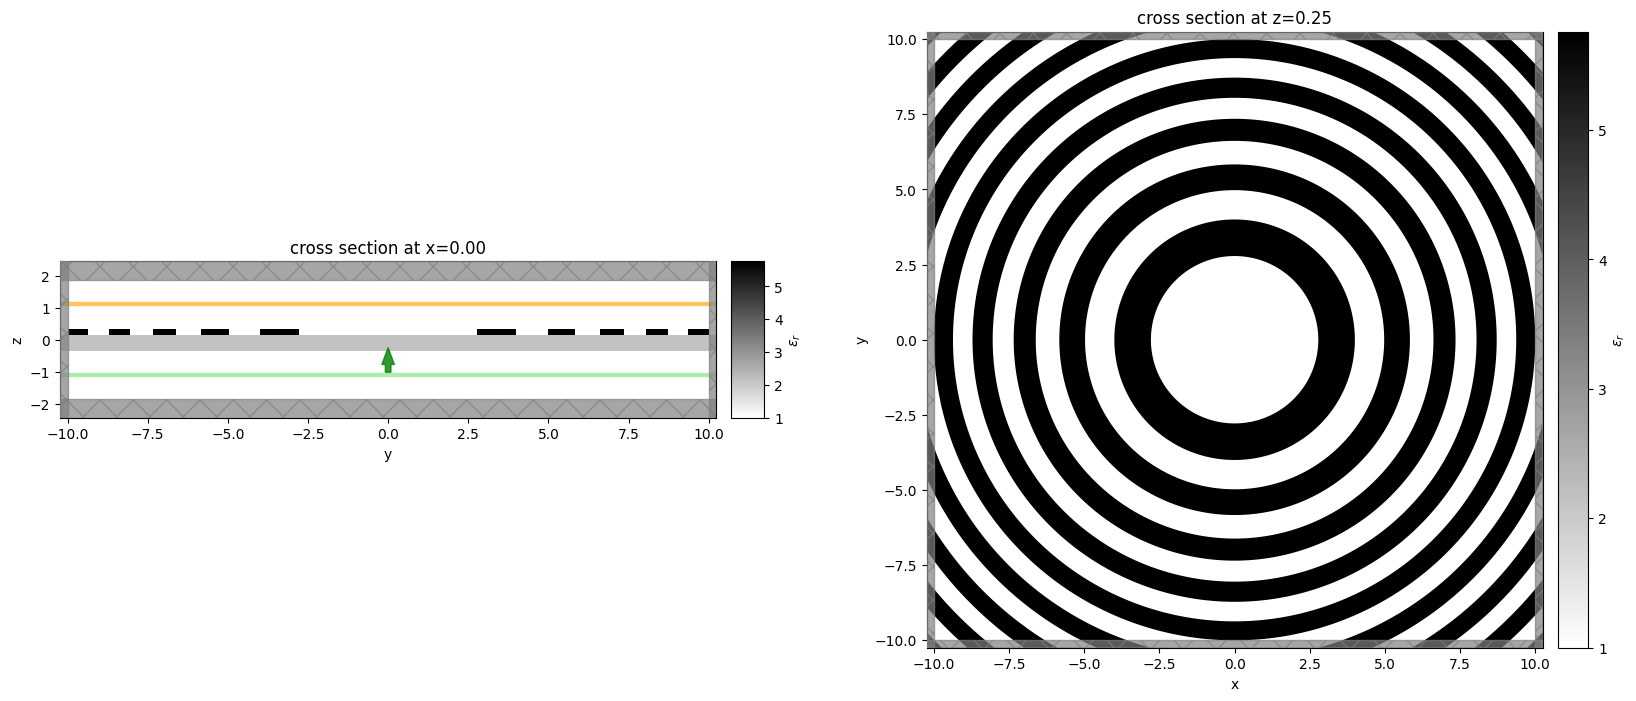

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
simulation.plot_eps(x=0, ax=ax1)
simulation.plot_eps(
    z=-length_z / 2 + space_below_sub + height_sub + height_lens / 2, ax=ax2
)
plt.show()


## Run Simulation

Now we can run the simulation and download the results


In [9]:
import tidy3d.web as web

sim_data = web.run(
    simulation, task_name="zone_plate", path="data/simulation.hdf5", verbose=True
)


03:07:22 PST Created task 'zone_plate' with task_id                             
             'fdve-8b7b8eb6-7401-48f1-bcc8-c560f11d1b2d' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=247583;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b7b8eb6-7401-48f1-bcc8-c560f11d1b2d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=257075;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b7b8eb6-7401-48f1-bcc8-c560f11d1b2d\taskId]8;;\]8;id=247583;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b7b8eb6-7401-48f1-bcc8-c560f11d1b2d\=]8;;\]8;id=812810;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b7b8eb6-7401-48f1-bcc8-c560f11d1b2d\fdve]8;;\]8;id=247583;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b7b8eb6-7401-48f1-bcc8-c560f11d1b2d\-8b7b8eb6-740]8;;\
             ]8;id=247583;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b7b8eb6-7401-48f1-bcc8-c560f11d1b2d\1-48f1-bcc8-c560f11d1b2d']8;;\.

Output()

03:07:23 PST status = queued

Output()

03:07:27 PST status = preprocess

03:07:30 PST Maximum FlexCredit cost: 1.182. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

03:08:09 PST early shutoff detected at 36%, exiting.

             status = postprocess

Output()

03:08:12 PST status = success

             View simulation result at                                          
             ]8;id=322351;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b7b8eb6-7401-48f1-bcc8-c560f11d1b2d\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=374598;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b7b8eb6-7401-48f1-bcc8-c560f11d1b2d\taskId]8;;\]8;id=322351;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b7b8eb6-7401-48f1-bcc8-c560f11d1b2d\=]8;;\]8;id=84623;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b7b8eb6-7401-48f1-bcc8-c560f11d1b2d\fdve]8;;\]8;id=322351;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b7b8eb6-7401-48f1-bcc8-c560f11d1b2d\-8b7b8eb6-740]8;;\
             ]8;id=322351;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8b7b8eb6-7401-48f1-bcc8-c560f11d1b2d\1-48f1-bcc8-c560f11d1b2d']8;;\.

Output()

03:08:15 PST loading simulation from data/simulation.hdf5

             WARNING: Structure at 'structures[57]' has bounds that extend      
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 3 WARNING messages.                            

## Visualization 

Let's inspect the near field using the Tidy3D builtin field visualization methods.  
For more details see the documentation of [tidy3d.SimulationData](../api/_autosummary/tidy3d.SimulationData.html?highlight=SimulationData).

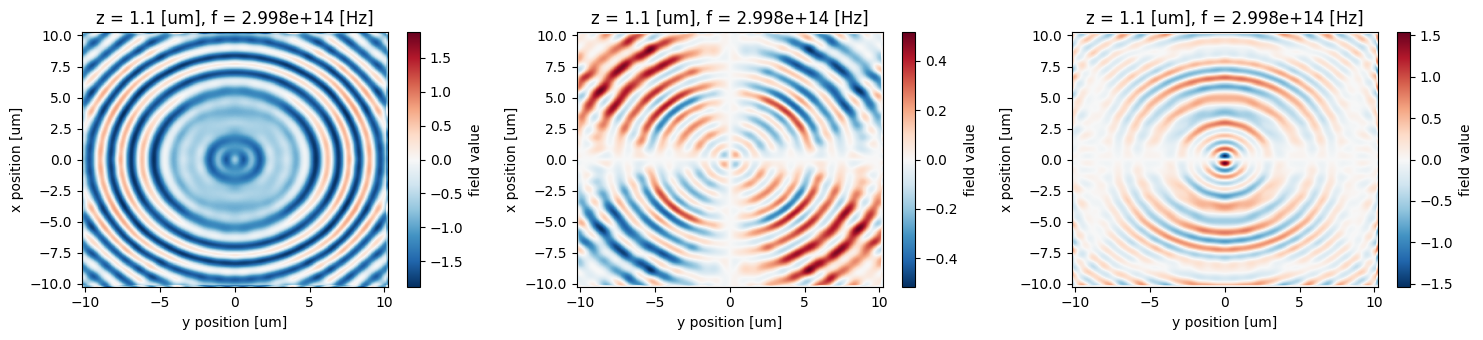

In [10]:
near_field_data = sim_data["nearfield"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3.5))
near_field_data.Ex.real.plot(ax=ax1)
near_field_data.Ey.real.plot(ax=ax2)
near_field_data.Ez.real.plot(ax=ax3)
plt.show()


## Getting Far Field Data

The [FieldProjectionCartesianMonitor](../api/_autosummary/tidy3d.FieldProjectionCartesianMonitor.html) object ensures that the projected fields are already computed on the server during the simulation run.

The projected fields can then be used to quickly return various quantities such as power and radar cross section.

For this example, we use `FieldProjectionCartesianData.fields_cartesian` to get the fields at the previously-set `x,y,z` points as an `xarray Dataset`.

In [11]:
projected_fields = sim_data[monitor_far.name].fields_cartesian


## Plot Results
Now we can plot the near and far fields together

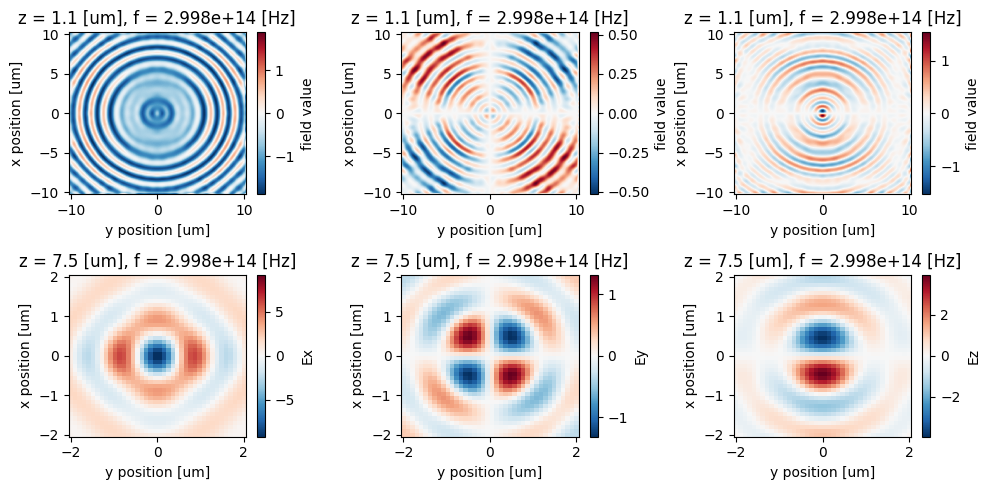

In [12]:
# plot everything
f, (axes_near, axes_far) = plt.subplots(2, 3, tight_layout=True, figsize=(10, 5))


def pmesh(xs, ys, array, ax, cmap):
    im = ax.pcolormesh(xs, ys, array.T, cmap=cmap, shading="auto")
    return im


ax1, ax2, ax3 = axes_near
im = near_field_data.Ex.real.plot(ax=ax1)
im = near_field_data.Ey.real.plot(ax=ax2)
im = near_field_data.Ez.real.plot(ax=ax3)

ax1, ax2, ax3 = axes_far
im = projected_fields["Ex"].real.plot(ax=ax1)
im = projected_fields["Ey"].real.plot(ax=ax2)
im = projected_fields["Ez"].real.plot(ax=ax3)

plt.show()


We can also use the far field data and plot the field intensity to see the focusing effect.

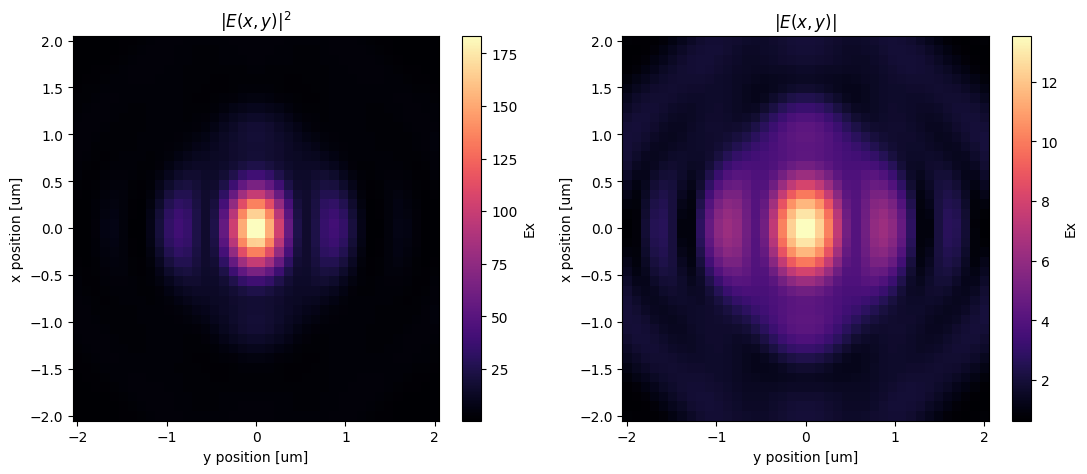

In [13]:
intensity = 0
for field in ("Ex", "Ey", "Ez"):
    intensity += np.abs(projected_fields[field].isel(z=0, f=0)) ** 2

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
np.sqrt(intensity).plot(ax=ax2, cmap="magma")
intensity.plot(ax=ax1, cmap="magma")

ax1.set_title("$|E(x,y)|^2$")
ax2.set_title("$|E(x,y)|$")

plt.show()
